# Asignement 02
name : Marta Campo Mascaray, Paula Cantí Herreros, Victor Garcia Cervantes

number : 15751767 , 

Queuing theory tells us that for FIFO scheduling the average waiting times are shorter for an M/M/n queue and a system load ρ and processor capacity μ than for a single M/M/1 queue with the same load characteristics (and thus an n-fold lower arrival rate). Of course, ρ must be less than one, but the experiment only becomes interesting when ρ is not much less than one.

### EXERCISE 2
Write a DES program to verify this for n=1, n=2 and n=4. Make sure that your result has a high and known statistical significance. How does the number of measurements required to attain this depend on ρ?

Being n the number of servers. Remember that we are using the Kendall notation A/B/m, where the different elements stand for:
- A : Distribution of durations between arrival times
- B : Distribution of service time durations per customer
and the M distribution stands for Markov - memoryless, as this is the exponential distribution.

So we have to implement a DES (discrete event simulation) for M/M/1 , M/M/2 and M/M/4

- The basic elements of a SimPy process are:
 - simpy.Environment = env : resulting object provides a collection of methods to interact and control the simulation
 - `yield` : Allows us to attach processes to the simulation. We can communicate with the simulation through the yield statement
 - env.timeout(delay) : Modules the passage of time between events in the simulation
 - env.process() : Allows us to attach to the current simulation the `yield`ed processes
 - env.run() : Runs the current process
    

- The waiting time of the customer will be : the time at which a new server becomes available - arrival time of the customer.
- Customers need to `.request` for a server, which is a `.resource` of the environment
- random.expovariate(lambda) is used to return a random floating point number with exponential distribution, being the parameter lambda $\lambda = \frac{1}{DesiredMean}$

In [1]:
import simpy
import numpy as np
import random 
import matplotlib.pyplot as plt


    
def customer(env, server, service_time, wait_times):
    """Creating an environment and process for the arriving customers process."""
    
    arrival_time = env.now    # Records the time at which this function is called, and therefore a client arrives
    with server.request() as req:   # Customer asks for a server 
        yield req                   # The process stops until a server becomes available
        wait_times.append(env.now - arrival_time)  # Append the waiting time of the customer
        yield env.timeout(service_time())  # Process stops until the service time a server takes passes.
    

def simulate_queue(env, arrival_rate, service_time, num_servers, sim_duration, wait_times):
    """Simulation of an the M/M/n queue."""
    server = simpy.Resource(env, capacity=num_servers) # Creates server as a resource of the environment.
                                                # Capacity of this resource is n
        
    def arrival_process():
        """Continuosly simulates the arrival of new customers."""
        while env.now < sim_duration:
            yield env.timeout(random.expovariate(arrival_rate))  # Simulates the time between arrivals, being these
                                                # distributed using an exponential distribution.
            env.process(customer(env, server, service_time, wait_times))  # Starts a new customer process
    
    env.process(arrival_process())   # Begins the arrival process
    yield env.timeout(sim_duration)  # Runs the simulation for the desired simulation_time


        
def run_simulation(arrival_rate, service_rate, num_servers, sim_duration, num_replications):
    """Run the simulation num_replications times, and return the mean waiting time of the customers, and the mean
    standard deviation."""
    wait_times = []  # Generates a blank list

    # Run the simulation several times
    for _ in range(num_replications):
        env = simpy.Environment()   # Each replica generates a new simpy environment
        
        service_time = lambda: random.expovariate(service_rate)  # For each replica randomly generate a lambda 
                                                                 #  parameter.
            
        replication_wait_times = [] # Creates a blank-replica list for each simulation so the overall data 
                                    #  doesn't get erased.
            
        env.process(simulate_queue(env, arrival_rate, service_time, num_servers, sim_duration, replication_wait_times))
            # Create the current process that we will run with the parameters for the current simulation
            
        env.run()
        wait_times.extend(replication_wait_times) # Extend the overall data with the current waiting_times

        
    return np.mean(wait_times), np.std(wait_times)

Defining the system load of the system as $\rho = \frac{\lambda}{n \mu}$ we can quickly realize that, in order for the system to not collapse, we will need $\rho < 1$. Otherwise the queue would start getting longer and longer and the system would collapse.

Some predictions that we can make are:
- For smaller values of $\rho$, the servers will be able to work much freely, and smaller time_simulation values will be needed to reach equilibrium.
- For values of the system load $\rho \approx 1$, the system is heavily loadad. We can expect a higher variance in the waiting times, and a higher value for time simulation in order to reach equilibrium.

In [2]:
########### Parameters ################
arrival_rate = 5   # Lambda = 1 / Mean
service_rate = 7   # Mu
sim_duration = 1000  # Time units
num_replications = 1  # Number of replications for significance
num_servers_list = [1, 2, 4]  # n values to test

# Run the simulation for one single time to make sure everything runs smoothly

num_servers = num_servers_list[0]
rho = arrival_rate / (num_servers * service_rate)  # Calculate system load.
print(f"Simulating M/M/{num_servers} queue with ρ = {rho:.2f}")
mean_wait, std_wait = run_simulation(arrival_rate, service_rate, num_servers, sim_duration, num_replications)
print(f"Average waiting time: {mean_wait:.4f}, Std. Dev: {std_wait:.4f}")

Simulating M/M/1 queue with ρ = 0.71
Average waiting time: 0.3156, Std. Dev: 0.4233


In [12]:
#### 100 Replica ####

########### Parameters ################
arrival_rate = 5   # Lambda = 1 / Mean
rho_list = [0.7,0.8,0.9,0.95]
service_rate = 7   # Mu
sim_duration = 1000  # Time units
num_replications = 100  # Number of replications for significance
num_servers_list = [1, 2, 4]  # n values to test

# Run the simulation several times to get statistical significance
average_waiting_times_little = np.zeros(shape = (len(num_servers_list),len(rho_list)))
standard_deviations_little = np.zeros(shape = (len(num_servers_list),len(rho_list)))
for n,num_servers in enumerate(num_servers_list):
    for i,rho in enumerate(rho_list):
        rho = rho_list[i]
        service_rate = arrival_rate / (num_servers * rho)
        print(f"Simulating M/M/{num_servers} queue with ρ = {rho:.2f}")
        mean_wait, std_wait = run_simulation(arrival_rate, service_rate, num_servers, sim_duration, num_replications)
        print(f"Average waiting time: {mean_wait:.4f}, Std. Dev: {std_wait:.4f}")
        average_waiting_times_little[n,i] = mean_wait
        standard_deviations_little[n,i] = std_wait


Simulating M/M/1 queue with ρ = 0.70
Average waiting time: 0.3195, Std. Dev: 0.4360
Simulating M/M/1 queue with ρ = 0.80
Average waiting time: 0.6437, Std. Dev: 0.7932
Simulating M/M/1 queue with ρ = 0.90
Average waiting time: 1.5825, Std. Dev: 1.6960
Simulating M/M/1 queue with ρ = 0.95
Average waiting time: 3.1216, Std. Dev: 3.3826
Simulating M/M/2 queue with ρ = 0.70
Average waiting time: 0.2691, Std. Dev: 0.4203
Simulating M/M/2 queue with ρ = 0.80
Average waiting time: 0.5675, Std. Dev: 0.7649
Simulating M/M/2 queue with ρ = 0.90
Average waiting time: 1.5215, Std. Dev: 1.7437
Simulating M/M/2 queue with ρ = 0.95
Average waiting time: 3.2060, Std. Dev: 3.4701
Simulating M/M/4 queue with ρ = 0.70
Average waiting time: 0.2024, Std. Dev: 0.3905
Simulating M/M/4 queue with ρ = 0.80
Average waiting time: 0.4815, Std. Dev: 0.7420
Simulating M/M/4 queue with ρ = 0.90
Average waiting time: 1.4353, Std. Dev: 1.7563
Simulating M/M/4 queue with ρ = 0.95
Average waiting time: 3.0179, Std. Dev:

In [43]:
#### 2000 Replica ####

########### Parameters ################
arrival_rate = 5   # Lambda = 1 / Mean
rho_list = [0.7,0.8,0.9,0.95]
service_rate = 7   # Mu
sim_duration = 1000  # Time units
num_replications = 2000  # Number of replications for significance
num_servers_list = [1, 2, 4]  # n values to test

# Run the simulation several times to get statistical significance
average_waiting_times = np.zeros(shape = (len(num_servers_list),len(rho_list)))
standard_deviations = np.zeros(shape = (len(num_servers_list),len(rho_list)))
for n,num_servers in enumerate(num_servers_list):
    for i,rho in enumerate(rho_list):
        rho = rho_list[i]
        service_rate = arrival_rate / (num_servers * rho)
        print(f"Simulating M/M/{num_servers} queue with ρ = {rho:.2f}")
        mean_wait, std_wait = run_simulation(arrival_rate, service_rate, num_servers, sim_duration, num_replications)
        print(f"Average waiting time: {mean_wait:.4f}, Std. Dev: {std_wait:.4f}")
        average_waiting_times[n,i] = mean_wait
        standard_deviations[n,i] = std_wait
    

Simulating M/M/1 queue with ρ = 0.70
Average waiting time: 0.3275, Std. Dev: 0.4461
Simulating M/M/1 queue with ρ = 0.80
Average waiting time: 0.6356, Std. Dev: 0.7741
Simulating M/M/1 queue with ρ = 0.90
Average waiting time: 1.5816, Std. Dev: 1.7460
Simulating M/M/1 queue with ρ = 0.95
Average waiting time: 3.2799, Std. Dev: 3.4151
Simulating M/M/2 queue with ρ = 0.70
Average waiting time: 0.2682, Std. Dev: 0.4207
Simulating M/M/2 queue with ρ = 0.80
Average waiting time: 0.5679, Std. Dev: 0.7676
Simulating M/M/2 queue with ρ = 0.90
Average waiting time: 1.5194, Std. Dev: 1.7791
Simulating M/M/2 queue with ρ = 0.95
Average waiting time: 3.3225, Std. Dev: 3.5905
Simulating M/M/4 queue with ρ = 0.70
Average waiting time: 0.2013, Std. Dev: 0.3848
Simulating M/M/4 queue with ρ = 0.80
Average waiting time: 0.4704, Std. Dev: 0.7199
Simulating M/M/4 queue with ρ = 0.90
Average waiting time: 1.4024, Std. Dev: 1.7564
Simulating M/M/4 queue with ρ = 0.95
Average waiting time: 3.1411, Std. Dev:

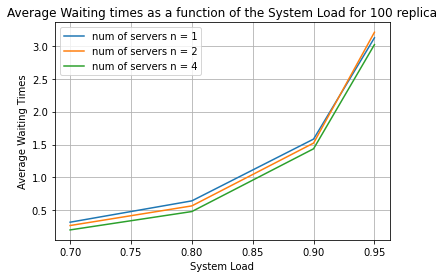

In [13]:
####### Graphs for 100 replica ######

for n,num_servers in enumerate(num_servers_list):
    plt.plot(rho_list,average_waiting_times_little[n,:],label = f'num of servers n = {num_servers}')
    
plt.legend()
plt.grid()
plt.xlabel('System Load')
plt.ylabel('Average Waiting Times')
plt.title('Average Waiting times as a function of the System Load for 100 replica')
plt.show()

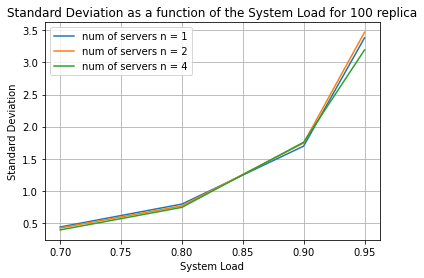

In [15]:
####### Graphs for 100 replica ######

for n,num_servers in enumerate(num_servers_list):
    plt.plot(rho_list,standard_deviations_little[n,:],label = f'num of servers n = {num_servers}')
    
plt.legend()
plt.grid()
plt.xlabel('System Load')
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation as a function of the System Load for 100 replica')
plt.show()

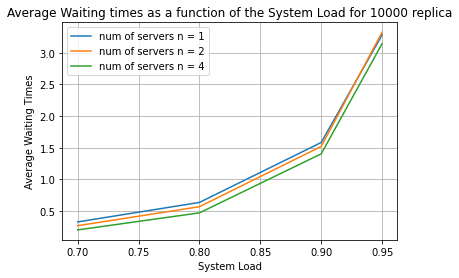

In [45]:
####### Graphs for 2000 replica ######

for n,num_servers in enumerate(num_servers_list):
    plt.plot(rho_list,average_waiting_times[n,:],label = f'num of servers n = {num_servers}')
    
plt.legend()
plt.grid()
plt.xlabel('System Load')
plt.ylabel('Average Waiting Times')
plt.title('Average Waiting times as a function of the System Load for 10000 replica')
plt.show()

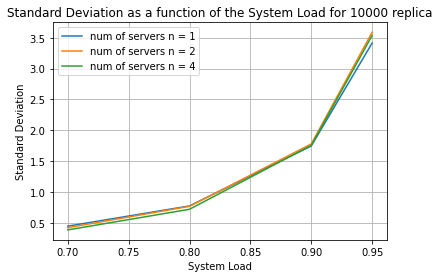

In [46]:
####### Graphs for 2000 replica ######

for n,num_servers in enumerate(num_servers_list):
    plt.plot(rho_list,standard_deviations[n,:],label = f'num of servers n = {num_servers}')
    
plt.legend()
plt.grid()
plt.xlabel('System Load')
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation as a function of the System Load for 10000 replica')
plt.show()

## Standard Error (SEM)
$$SEM = \frac{\sigma}{\sqrt{Replications}}$$

In [47]:
## 100 Replica
coeffvar = np.zeros(shape=(len(num_servers_list),len(rho_list)))
num_repl = 100

for k,n in enumerate(num_servers_list):
    print(f'Number of servers {n}')
    for i in range(len(average_waiting_times_little)+1):
        rho = rho_list[i]
        cv = standard_deviations_little[k,i] / np.sqrt(num_repl)
        coeffvar[k,i] = cv
        print(f'rho : {rho}  ,  Average Waiting Time {average_waiting_times_little[k,i]}  ,  SEM = {coeffvar[k,i]} \\' )

Number of servers 1
rho : 0.7  ,  Average Waiting Time 0.3194893092876984  ,  SEM = 0.04359657336963268 \
rho : 0.8  ,  Average Waiting Time 0.6437087685825967  ,  SEM = 0.07931504529145436 \
rho : 0.9  ,  Average Waiting Time 1.5825171095227641  ,  SEM = 0.16960393675690216 \
rho : 0.95  ,  Average Waiting Time 3.1215571809273803  ,  SEM = 0.3382569854305949 \
Number of servers 2
rho : 0.7  ,  Average Waiting Time 0.2690628067442659  ,  SEM = 0.04202937152724193 \
rho : 0.8  ,  Average Waiting Time 0.5674521658518757  ,  SEM = 0.0764929465360228 \
rho : 0.9  ,  Average Waiting Time 1.5215279695539263  ,  SEM = 0.17437470972723973 \
rho : 0.95  ,  Average Waiting Time 3.2059749557071027  ,  SEM = 0.34701087515507467 \
Number of servers 4
rho : 0.7  ,  Average Waiting Time 0.2024220154968051  ,  SEM = 0.039052575693013306 \
rho : 0.8  ,  Average Waiting Time 0.48151864041443615  ,  SEM = 0.07420342957775024 \
rho : 0.9  ,  Average Waiting Time 1.4353053604708292  ,  SEM = 0.175631330131

In [52]:
coeffvar_large = np.zeros(shape=(len(num_servers_list),len(rho_list)))
num_repl = 2000

for k,n in enumerate(num_servers_list):
    print(f'Number of servers {n}')
    for i in range(len(average_waiting_times)+1):
        rho = rho_list[i]
        cv = standard_deviations[k,i] / np.sqrt(num_repl)
        coeffvar_large[k,i] = cv
        print(f'rho : {rho}  ,  Average Waiting Time {average_waiting_times[k,i]}  ,  SEM = {coeffvar_large[k,i]} \\' )

Number of servers 1
rho : 0.7  ,  Average Waiting Time 0.32752580072059434  ,  SEM = 0.009975842659288418 \
rho : 0.8  ,  Average Waiting Time 0.6356145414031085  ,  SEM = 0.017309301951232585 \
rho : 0.9  ,  Average Waiting Time 1.5815779618221089  ,  SEM = 0.0390417004680604 \
rho : 0.95  ,  Average Waiting Time 3.2799222505432555  ,  SEM = 0.07636338047538162 \
Number of servers 2
rho : 0.7  ,  Average Waiting Time 0.2681752345522127  ,  SEM = 0.009407353311016187 \
rho : 0.8  ,  Average Waiting Time 0.5678947240503425  ,  SEM = 0.017163352694150813 \
rho : 0.9  ,  Average Waiting Time 1.5193926822919066  ,  SEM = 0.03978233925976155 \
rho : 0.95  ,  Average Waiting Time 3.322535676607552  ,  SEM = 0.08028615253387125 \
Number of servers 4
rho : 0.7  ,  Average Waiting Time 0.2013002477820486  ,  SEM = 0.008604953743472593 \
rho : 0.8  ,  Average Waiting Time 0.47043869798217924  ,  SEM = 0.01609667577716553 \
rho : 0.9  ,  Average Waiting Time 1.4023750396929333  ,  SEM = 0.0392732

## Confidence Interval test
In order to determine whether the standard deviation is good enough we will compute the Confidence Interval of the mean waiting time. The CI formula is the following:
$$CI = \overline{x} \pm z\cdot SEM$$
with each parameter being:
- $\overline{x}$ : Sample mean waiting time
- $\sigma$ : Standard Deviation
- n : Number of replicas
- z : The critical value from the standard normal distribution

In order to know the z-value we just need to consult the z-table. We would like to accomplish a 95% confidence, which corresponds to a z-value of 1.96

In [49]:
## 100 Replica
z = 1.96
n = 100
CImin = np.zeros(shape=(len(num_servers_list),len(rho_list)))
CImax = np.zeros(shape=(len(num_servers_list),len(rho_list)))
interval = np.zeros(shape=(len(num_servers_list),len(rho_list)))
for k,n in enumerate(num_servers_list):
    for i in range(len(average_waiting_times_little)+1):
        rho = rho_list[i]
        CIm = average_waiting_times_little[k,i] - z * coeffvar[k,i]
        CIM = average_waiting_times_little[k,i] + z * coeffvar[k,i]
        intervali = CIM - CIm
        CImin[k,i] = CIm
        CImax[k,i] = CIM
        interval[k,i] = intervali
        print(f'rho : {rho}  ,  Average Waiting Time {average_waiting_times_little[0,i]}  ,  [{CIm},{CIM}] \\' )

rho : 0.7  ,  Average Waiting Time 0.3194893092876984  ,  [0.23404002548321837,0.4049385930921785] \
rho : 0.8  ,  Average Waiting Time 0.6437087685825967  ,  [0.4882512798113462,0.7991662573538473] \
rho : 0.9  ,  Average Waiting Time 1.5825171095227641  ,  [1.250093393479236,1.9149408255662923] \
rho : 0.95  ,  Average Waiting Time 3.1215571809273803  ,  [2.458573489483414,3.7845408723713465] \
rho : 0.7  ,  Average Waiting Time 0.3194893092876984  ,  [0.18668523855087174,0.3514403749376601] \
rho : 0.8  ,  Average Waiting Time 0.6437087685825967  ,  [0.41752599064127105,0.7173783410624804] \
rho : 0.9  ,  Average Waiting Time 1.5825171095227641  ,  [1.1797535384885365,1.8633024006193162] \
rho : 0.95  ,  Average Waiting Time 3.1215571809273803  ,  [2.5258336404031563,3.886116271011049] \
rho : 0.7  ,  Average Waiting Time 0.3194893092876984  ,  [0.12587896713849903,0.2789650638551112] \
rho : 0.8  ,  Average Waiting Time 0.6437087685825967  ,  [0.33607991844204566,0.6269573623868266

In [53]:
## 1000 Replica
z = 1.96
n = 2000
CImin = np.zeros(shape=(len(num_servers_list),len(rho_list)))
CImax = np.zeros(shape=(len(num_servers_list),len(rho_list)))
interval_large = np.zeros(shape=(len(num_servers_list),len(rho_list)))
for k,n in enumerate(num_servers_list):
    for i in range(len(average_waiting_times_little)+1):
        rho = rho_list[i]
        CIm = average_waiting_times[k,i] - z * coeffvar_large[k,i]
        CIM = average_waiting_times[k,i] + z * coeffvar_large[k,i]
        intervali = CIM - CIm
        CImin[k,i] = CIm
        CImax[k,i] = CIM
        interval_large[k,i] = intervali
        print(f'rho : {rho}  ,  Average Waiting Time {average_waiting_times[0,i]}  ,  [{CIm},{CIM}] \\' )

rho : 0.7  ,  Average Waiting Time 0.32752580072059434  ,  [0.307973149108389,0.34707845233279966] \
rho : 0.8  ,  Average Waiting Time 0.6356145414031085  ,  [0.6016883095786926,0.6695407732275244] \
rho : 0.9  ,  Average Waiting Time 1.5815779618221089  ,  [1.5050562289047105,1.6580996947395072] \
rho : 0.95  ,  Average Waiting Time 3.2799222505432555  ,  [3.1302500248115077,3.4295944762750032] \
rho : 0.7  ,  Average Waiting Time 0.32752580072059434  ,  [0.249736822062621,0.2866136470418044] \
rho : 0.8  ,  Average Waiting Time 0.6356145414031085  ,  [0.5342545527698068,0.6015348953308781] \
rho : 0.9  ,  Average Waiting Time 1.5815779618221089  ,  [1.441419297342774,1.5973660672410392] \
rho : 0.95  ,  Average Waiting Time 3.2799222505432555  ,  [3.1651748176411645,3.4798965355739395] \
rho : 0.7  ,  Average Waiting Time 0.32752580072059434  ,  [0.18443453844484234,0.21816595711925488] \
rho : 0.8  ,  Average Waiting Time 0.6356145414031085  ,  [0.4388892134589348,0.501988182505423

In [54]:
# Now we compute the percentage of the value of the average that the CI represents
percentages = np.zeros(shape=(len(num_servers_list),len(rho_list)))
percentages_large = np.zeros(shape=(len(num_servers_list),len(rho_list)))
for k,n in enumerate(num_servers_list):
    print(f'n = {n}')
    for i in range(len(average_waiting_times_little)+1):
        rho = rho_list[i]
        perc = (interval[k,i] / standard_deviations_little[k,i]) * 100
        perc_lar = (interval_large[k,i] / standard_deviations[k,i]) * 100
        percentages[k,i] = perc
        percentages_large[k,i] = perc_lar
        print(f'rho = {rho} , % of CI small reps = {percentages[k,i]}%  ,  % of CI high reps = {percentages_large[k,i]}% ')

n = 1
rho = 0.7 , % of CI small reps = 39.20000000000001%  ,  % of CI high reps = 8.765386471799184% 
rho = 0.8 , % of CI small reps = 39.2%  ,  % of CI high reps = 8.765386471799182% 
rho = 0.9 , % of CI small reps = 39.199999999999996%  ,  % of CI high reps = 8.765386471799175% 
rho = 0.95 , % of CI small reps = 39.20000000000001%  ,  % of CI high reps = 8.765386471799165% 
n = 2
rho = 0.7 , % of CI small reps = 39.20000000000001%  ,  % of CI high reps = 8.76538647179917% 
rho = 0.8 , % of CI small reps = 39.2%  ,  % of CI high reps = 8.76538647179919% 
rho = 0.9 , % of CI small reps = 39.2%  ,  % of CI high reps = 8.765386471799175% 
rho = 0.95 , % of CI small reps = 39.2%  ,  % of CI high reps = 8.765386471799166% 
n = 4
rho = 0.7 , % of CI small reps = 39.20000000000001%  ,  % of CI high reps = 8.765386471799168% 
rho = 0.8 , % of CI small reps = 39.20000000000001%  ,  % of CI high reps = 8.765386471799175% 
rho = 0.9 , % of CI small reps = 39.199999999999996%  ,  % of CI high rep

[Methods] In order to make sure that our results have a high and known significance we will try to construct the confidence interval for each measure.

To evaluate the statistical significance we have followed this steps:
1. Firstly, compute the mean standard deviation for each combination of n and system load ($\rho$) of interest
2. Then, calculate teh standard error (SEM), whose expression is:
$$SEM = \frac{\sigma}{\sqrt{Replicas}}$$
3. Lastly, with these values we construct the CI for 95% confidence as:
$$CI = AverageWaitingTime \pm z\cdot SEM \quad , \quad z = 1.96$$
4. If the CI is narrow compared to the mean standard deviation (<10%), this means that the results have high statistical significance.
Firstly we conducted these steps for a number of replicas n = 100. With these values we got a really wide confidence interval. Since we know that the average standard deviation follows $SEM \varpropto \frac{1}{\sqrt{Replicas}}$, in order to narrow the CI. We studied both $\textit{num replicas} = 1000,10000$.

A narrow CI indicates a high precision and significance.

[Discussion] 
How does the number of measurements required to attain this depend on ρ?

As $\rho$ approaches 1, the variability of the system increases because small fluctuations in arrival or service times significantly affect the waiting times. As a consequence, high values for standard deviation are expected in high-load systems, due to inherent stochasticity.

The system load is defined as:
$$\rho = \frac{\lambda}{n \mu}$$
For a single-server queue, we can express the Mean and Variance of the waiting time as:
$$E(W) = \frac{\rho}{\mu(1-\rho)} \quad ;\quad Var(W) = \frac{2\rho - \rho^2}{\mu^2(1-\rho)^2} $$
Studying these two expressions, we can extract the following conclusions:
- As $\rho \rightarrow 1$, the mean tends to $\infty$, meaning the system becomes increasingly congested.
- The denominator of the variance becomes small as $\rho \rightarrow 1$, causing $Var(W)\rightarrow \infty$.
Intuitively, the variability increases due to longer queues and the higher frequency in the contention of servers.

We can conclude that the variance of waiting time depends inversely on $(1-\rho)^2$, which diminishes as $\rho \rightarrow 1$. Thus, a higher $\rho$ leads to larger queues and greater unpredactibility.